## Preliminary Setup

### Install and Import Packages

In [ ]:
!pip install pulp

     |████████████████████████████████| 14.2 MB 6.4 MB/s 


In [ ]:
# import packages
import copy
import itertools
import matplotlib
import matplotlib.style
import matplotlib.pyplot as plt
from tqdm.notebook import tqdm
from pulp import *
import pandas as pd
import numpy as np
from numpy import random
import sys

  



# SINGLE AGENT

##Single Agent - LP Method

### Functions for LP Model

In [ ]:
# Test if a node's constraints are met
def test_node_constraints_met (current_node_condition):

  tasks_load = current_node_condition[0]
  power_load = current_node_condition[1]
  tasks_limit = current_node_condition[2]
  power_load_limit = current_node_condition[3]

  if ((power_load + task_power_requirement) > power_load_limit):
    return False
  elif ((tasks_load + 1) > tasks_limit):
    return False
  else:
    return True

In [ ]:
def intialize_nodes():

  states_and_conditions_of_each_action = []
  states_and_name_of_each_action = []

  for state in range(num_of_states):

    conditions_of_each_action = {}
    name_of_each_action = []

    for action in range(num_of_actions):

      node = "T_{}_{}".format(state, action)

      conditions_of_each_action[node] = [random.randint(9), # num of tasks
                                      random.randint(900), # power_load
                                      random.randint(7,10), # max tasks
                                      random.randint(700,1000), # max power
                                      round(random.rand(),3)] # transmission time
      
      name_of_each_action.append(node)

    states_and_conditions_of_each_action.append(conditions_of_each_action)
    states_and_name_of_each_action.append(name_of_each_action)

  states_and_actions = [states_and_name_of_each_action, states_and_conditions_of_each_action]
  return states_and_actions

In [ ]:
def generate_problem_with_solution():

  solution = "Undefined"
  counter = 0
  optimal_policy = []
    
  while (solution is not "Optimal"):
      
      states_and_actions = intialize_nodes()
      
      all_actions_list = []
      all_actions_per_state_list = []
      for a in states_and_actions[0]:
        all_actions_list += a
        all_actions_per_state_list.append(a)
      
      conditions_of_all_actions = {}
      for condition in states_and_actions[1]:
        conditions_of_all_actions.update(condition)

      # Creates the 'prob' variable to contain the problem data
      node_vars = LpVariable.dict("", (all_actions_list), 0, None, LpBinary)

      prob = LpProblem("TransmissionTimeProb", LpMinimize)

      # The objective function is added to prob first
      prob += lpSum([node_vars[n]*conditions_of_all_actions[n][4] for (n) in all_actions_list]), "Sum of Transmission Times"

      # Constraint added: Only one node can be chosen per category
      for nodes in all_actions_per_state_list:
        prob += lpSum([node_vars[n] for (n) in nodes]) == 1, "Only one node from {} is chosen".format(nodes)

      # Constraint added: Chosen node can not exceeed tasks limits
      for n in all_actions_list:  
        prob += lpSum(node_vars[n]*conditions_of_all_actions[n][0] + 1) <= conditions_of_all_actions[n][2], "Chosen node {} cannot exceed tasks limit".format(n)

      # Constraint added: Chosen node can not exceeed power limits
      for n in all_actions_list:  
        prob += lpSum(node_vars[n]*conditions_of_all_actions[n][1] + task_power_requirement) <= conditions_of_all_actions[n][3], "Chosen node {} cannot exceed power limit".format(n)

      # The problem data is written to an .lp file
      prob.writeLP("RoutingProblem.lp")

      # The problem is solved using PuLP's choice of Solver
      prob.solve()

      # The status of the solution is printed to the screen
      solution = LpStatus[prob.status]
      if solution is not 'Optimal':
        counter += 1

  # The optimised objective function value is printed to the screen 

  print (counter, "unsuccessful problem generations")

  state_counter = 0
  for node in all_actions_per_state_list:
    test_counter = 0
    for n in node:
      if test_node_constraints_met(conditions_of_all_actions[n]):
        test_counter += 1
    percentage_available = (test_counter/len(node))*100
    #print("{0:.3g}% of the nodes are available out of".format(percentage_available), len(node), "nodes in state", state_counter)
    state_counter += 1 

  
  for v in prob.variables():
    if v.varValue:
      optimal_policy.append(v.name) 

  print("Total transmission time {0:.6g}".format(value(prob.objective)))

  return optimal_policy, value(prob.objective), states_and_actions


### Run LP Model

In [ ]:
num_of_states =  4#@param {type:"number"}
num_of_actions =  100#@param {type:"number"}
task_power_requirement = 100

temp,total_transmission_time_lp, states_and_actions = generate_problem_with_solution()

lp_optimal_policy = []

for x in temp:
  lp_optimal_policy.append(x[1:])

lp_optimal_policy.sort()

print('Solution', lp_optimal_policy)

0 unsuccessful problem generations
Total transmission time 0.063
Solution ['T_0_22', 'T_1_84', 'T_2_72', 'T_3_64']


##Single Agent - Q Learning Method

### Functions for QL Model

In [ ]:
# Plot graphs
def plot_graphs(rewards, episode_length, failed_transitions):

  plt.figure().dpi = 1600
  plt.figure().set_size_inches(8, 5)

  plt.plot(rewards, label="Rewards per episode")

  plt.legend(loc="lower center", bbox_to_anchor=(0.5, 1.02), ncol= 3)
    
  plt.ylabel(f"Rewards")
  plt.xlabel("Episode #")

  plt.show()
  '''
  plt.plot(episode_length, label="Episode Length per episode")

  plt.legend(loc="lower center", bbox_to_anchor=(0.5, 1.02), ncol= 3)
    
  plt.ylabel(f"Episode Length")
  plt.xlabel("Episode #")

  plt.show()

  plt.plot(failed_transitions, label="Failed Transitions per episode")

  plt.legend(loc="lower center", bbox_to_anchor=(0.5, 1.02), ncol= 3)
    
  plt.ylabel(f"Failed Transitions")
  plt.xlabel("Episode #")

  plt.show()
  '''

In [ ]:
"""
    A epsilon-greedy policy based
    on a given Q-function and epsilon.
       
    Returns a function that takes the state
    as an input and returns the probabilities
    for each action in the form of a numpy array 
    of length of the action space(set of possible actions).
    """

def policyFunction(Q, state, epsilon, num_actions):
  
    Action_probabilities = np.ones(num_actions,
            dtype = float) * epsilon / num_actions
              
    best_action = np.argmax(Q[state])

    Action_probabilities[best_action] += (1.0 - epsilon)

    return Action_probabilities

In [ ]:
def agent(state, action):

  selected_node = states_and_actions[0][state][action]
  selected_node_conditions = states_and_actions[1][state][selected_node]

  transmission_time = selected_node_conditions[4]

  passed = test_node_constraints_met(selected_node_conditions)

  next_state = state + 1

  if passed:
    reward = -1*time_weight*transmission_time

    if next_state == num_of_states:
      done = True
      #print('Data Reached Viewer')
    else:
      done = False
      #print('Chose correct server')
    
  else:
    reward = -1*penalty_reward
    next_state = state
    done = False
    #print('Chose wrong server')

  return next_state, reward, done, selected_node

In [ ]:
def qLearning(epsilon):
    """
    Q-Learning algorithm: Off-policy TD control.
    Finds the optimal greedy policy while improving
    following an epsilon-greedy policy"""

    failed_transitions = [0]*num_episodes
       
    # Action value function
    Q = action_space 
   
    # Keeps track of useful statistics
    episode_lengths = np.zeros(num_episodes)
    episode_rewards = np.zeros(num_episodes)
    
    stats = [episode_lengths, episode_rewards]

    optimal_policy = []   
    obj_func_value = 0;

    epsilon_decay_value = epsilon/(END_EPSILON_DECAYING - START_EPSILON_DECAYING)
       
    # For every episode
    for ith_episode in tqdm(range(num_episodes), ascii=True, unit=' Episodes'):
           
        # Reset the environment
        state = 0
        failed_transition_counter = 0
           
        for t in itertools.count():
               
            # get probabilities of all actions from current state
            # based on the epsilon greedy policy function
            #print('State', state)
            #print('Q', Q)
            action_probabilities = policyFunction(Q, state, epsilon, action_space.shape[1])
   
            # choose action according to 
            # the probability distribution
            action = np.random.choice(np.arange(
                      len(action_probabilities)),
                       p = action_probabilities)
   
            # take action and get reward, transit to next state
            next_state, reward, done, selected_node = agent(state, action)

            # Update statistics
            stats[0][ith_episode] = t
            stats[1][ith_episode] += reward
            
            if next_state is state:
              failed_transition_counter += 1
              failed_transitions[ith_episode] = failed_transition_counter
               
            # TD Update
            best_next_action = np.argmax(Q[next_state])  
            td_target = reward + discount_factor * Q[next_state][best_next_action]
            td_delta = td_target - Q[state][action]
            Q[state][action] += alpha * td_delta

            if (ith_episode == (num_episodes-1)) and (state is not next_state):
              optimal_policy.append(selected_node)
              obj_func_value += reward

            # done is True if episode terminated   
            if done:
              break
                   
            state = next_state
        
        # Decaying is being done every episode if episode number is within decaying range
        if END_EPSILON_DECAYING >= ith_episode >= START_EPSILON_DECAYING:
            epsilon = abs(epsilon - epsilon_decay_value)
       
    return Q, stats, optimal_policy, failed_transitions, epsilon, obj_func_value

In [ ]:
def total_transmission_time(optimal_policy):

  total = 0

  conditions_of_all_actions = {}
  for condition in states_and_actions[1]:
    conditions_of_all_actions.update(condition)

  for node in optimal_policy:
    total += conditions_of_all_actions[node][4]

  return total

### Run QL Model

In [ ]:
num_episodes =  100#@param {type:"number"}
discount_factor =  .5
alpha = .6 
epsilon =  .1#@param {type:"number"}

# Epsilon Greedy Decay Parameters part 1
START_EPSILON_DECAYING = 1
END_EPSILON_DECAYING = num_episodes // 2

# factors for objective function or reward
time_weight =  1
penalty_reward =  1


action_space = np.zeros((num_of_states + 1,
                        num_of_actions))

Q, stats, ql_optimal_policy, failed_transitions, epsilon_end, final_obj_func_value = qLearning(epsilon)

ql_optimal_policy.sort()

if (lp_optimal_policy == ql_optimal_policy):
  print("Status: Matches LP Optimal Policy")

  
else:
  print("Status: Does not match LP Optimal Policy")
  set_difference_1 = set(lp_optimal_policy) - set(ql_optimal_policy)
  set_difference_2 = set(ql_optimal_policy) - set(lp_optimal_policy)
  list_difference = list(set_difference_1) + list(set_difference_2)
  print(list_difference)

print("QL Objective Function Value {0:.6g}".format(final_obj_func_value))
print("LP Objective Function Value {0:.6g}".format(total_transmission_time_lp))
print('Obj Func Value Diff:', total_transmission_time_lp + final_obj_func_value)
#print("Total transmission time QL {0:.6g}".format(total_transmission_time(ql_optimal_policy)))
#print('Time Diff:', total_transmission_time_lp - total_transmission_time(ql_optimal_policy))

print('LP Solution', lp_optimal_policy)
print('QL Solution', ql_optimal_policy)

plot_graphs(stats[1], stats[0], failed_transitions)

  0%|          | 0/100 [00:00<?, ? Episodes/s]

Status: Does not match LP Optimal Policy
['T_2_72', 'T_1_84', 'T_3_64', 'T_2_16', 'T_1_8', 'T_3_4']
QL Objective Function Value -0.212
LP Objective Function Value 0.063
Obj Func Value Diff: -0.149
LP Solution ['T_0_22', 'T_1_84', 'T_2_72', 'T_3_64']
QL Solution ['T_0_22', 'T_1_8', 'T_2_16', 'T_3_4']


TypeError: ignored

# MULTI AGENT

## MultiAgent - LP Method

### Functions for LP Model

In [ ]:
# Test if a node's constraints are met
def malp_test_node_constraints_met (current_node_condition):

  tasks_load = current_node_condition[0]
  power_load = current_node_condition[1]
  tasks_limit = current_node_condition[2]
  power_load_limit = current_node_condition[3]

  if power_load > power_load_limit:
    return False
  elif tasks_load > tasks_limit:
    return False
  else:
    return True

In [ ]:
def malp_intialize_nodes():

  states_and_conditions_of_each_action = []
  states_and_name_of_each_action = []

  for state in tqdm(range(num_of_states), ascii=True, unit=' state'):

    conditions_of_each_action = {}
    name_of_each_action = []

    for action in range(num_of_actions):

      node = "S{}_A{}".format(state, action)

      conditions_of_each_action[node] = [random.randint(9), # num of tasks
                                      random.randint(900), # power_load 
                                      random.randint(7,10), # max tasks 
                                      random.randint(700,1000), # max power 
                                      round(random.rand(),3)] # transmission time
      
      name_of_each_action.append(node)

    states_and_conditions_of_each_action.append(conditions_of_each_action)
    states_and_name_of_each_action.append(name_of_each_action)

  states_and_actions = [states_and_name_of_each_action, states_and_conditions_of_each_action]
  return states_and_actions

In [ ]:
def malp_constraints_update(selected_multiagent_action, one_agent_action, all_actions_conditions):

  temp_all_actions_conditions = copy.deepcopy(all_actions_conditions)

  for action_per_agent in selected_multiagent_action:
    if action_per_agent is one_agent_action:
      temp_all_actions_conditions[one_agent_action][0] += 1
      temp_all_actions_conditions[one_agent_action][1] += task_power_requirement
    
  return temp_all_actions_conditions, malp_test_node_constraints_met(temp_all_actions_conditions[one_agent_action])

In [ ]:
def malp_generate_problem_with_solution():

  solution = "Undefined"
  counter = 0
  state_counter = 0
  optimal_policy = []
    
  while (solution is not "Optimal"):

      print ("-- Begin Initialization --")
      
      states_and_actions = malp_intialize_nodes()

      multiagent_actions_list = []
      multiagent_actions_per_state_list = []
      all_actions_list = []
      all_actions_per_state_list = []

      print ("-- Create MultiAgent Action Space --")

      # Creates multiagent action space - UPDATED
      for actions in states_and_actions[0]:
        
        combine_agents_actions = list(itertools.product(actions, repeat = num_of_agents))
        
        all_actions_list += actions
        all_actions_per_state_list.append(actions)
        multiagent_actions_list += combine_agents_actions
        multiagent_actions_per_state_list.append(combine_agents_actions)

      print ("-- Create Node Conditions --")

      # Creates dict for each action transmission times - UPDATED
      conditions_of_all_actions = {}
      for condition in states_and_actions[1]:
        conditions_of_all_actions.update(condition)
      
      print ("-- Collect Transmission Times --")

      # Creates dict for multiagent action transmission times - UPDATED
      transmission_time_of_multiagent_actions = {}
      for multiagent_action in multiagent_actions_list:
        temp_transmission_time = []
        for action in multiagent_action:
          temp_transmission_time.append(conditions_of_all_actions[action][4])
        transmission_time_of_multiagent_actions[multiagent_action] = max(temp_transmission_time)

      # Creates the tuple needed for variable creation - based on number of agents - UPDATED
      test_variables_list = []

      print ("-- Create LP Variables --")

      for i in range(num_of_agents):
        test_variables_list.append(all_actions_list)

      print ("-- Convert LP Variables to Tuple --")

      test_variables_tuple = tuple(test_variables_list)

      print ("-- Convert Tuple for LP Problem --")

      # Creates the 'prob' variable to contain the problem data - UPDATED
      node_vars = LpVariable.dict("", test_variables_tuple, cat='Binary')

      print ("-- Initialize LP Problem --")

      prob = LpProblem("TranmissionTimeProb", LpMinimize)

      print ("-- Create LP Objective Function --")

      # The objective function is added to prob first - UPDATED
      prob += lpSum([node_vars[multiagent_action]*transmission_time_of_multiagent_actions[multiagent_action] for (multiagent_action) in multiagent_actions_list]), "Sum of Transmission Times"

      print ("-- Create C1 Constraint --")
      # Constraint added: Only one set of nodes can be chosen per state - UPDATED
      for set_of_nodes in tqdm(multiagent_actions_per_state_list, ascii=True, unit=' State'):
        prob += lpSum([node_vars[n] for n in set_of_nodes]) == 1, "C1: One set is chosen from {}".format(set_of_nodes)

      state_counter = 0

      print ("-- Create C2 & C3 Constraints --")

      # Constraint added: Chosen set of nodes can not exceeed tasks limits - UPDATED
      for all_multiagent_actions_per_state in tqdm(multiagent_actions_per_state_list, ascii=True, unit=' State'):

        test_counter = 0

        for multiagent_action in tqdm(all_multiagent_actions_per_state, ascii=True, unit=' multi-action'):  

          condition_test_counter = 0

          for index, one_agent_action in enumerate(multiagent_action):

            updated_conditions, constraints_met = malp_constraints_update(multiagent_action, one_agent_action, conditions_of_all_actions)
  
            # Constraint added: Chosen set of nodes can not exceeed tasks limits - UPDATED
            prob += lpSum(updated_conditions[one_agent_action][0] * node_vars[multiagent_action]) <= conditions_of_all_actions[one_agent_action][2], "C2: Task Limit {} - Action {} ".format(index, multiagent_action)
            
            # Constraint added: Chosen set of nodes can not exceeed power limits - UPDATED
            prob += lpSum(updated_conditions[one_agent_action][1] * node_vars[multiagent_action]) <= conditions_of_all_actions[one_agent_action][3] , "C3: Power Limit {} - Action {} ".format(index, multiagent_action)
  
            if constraints_met:
              condition_test_counter += 1
          
          if condition_test_counter == len(multiagent_action):
              test_counter += 1
        
        percentage_available = (test_counter/(len(all_multiagent_actions_per_state)))*100
        print("{0:.3g}% of the actions are available from".format(percentage_available), len(all_multiagent_actions_per_state), "actions in state", state_counter)
        print('\n')
        state_counter += 1 

      # The problem data is written to an .lp file - UPDATED
      print('-- Converting LP problem for PULP package --')
      prob.writeLP("RoutingProblem.lp")

      # The problem is solved using PuLP's choice of Solver - UPDATED
      print('-- Solving LP Problem --')
      prob.solve()

      # The status of the solution is printed to the screen - UPDATED
      solution = LpStatus[prob.status]
      if solution is not 'Optimal':
        counter += 1
        print("Reset: No Solution or Solution not Optimal")

  # The optimised objective function value is printed to the screen - UPDATED

  print (counter, "unsuccessful problem generations\n")
  
  for v in prob.variables():
    if v.varValue:
      optimal_policy.append(v.name) 

  print("Total transmission time {0:.6g}".format(value(prob.objective)))
  
  return optimal_policy, prob, states_and_actions

### Run LP Model

In [ ]:
num_of_agents =  3#@param {type:"number"}
num_of_states =  4#@param {type:"number"}
num_of_actions =  25#@param {type:"number"}
task_power_requirement = 100#@param {type:"number"}

# https://towardsdatascience.com/federated-learning-a-step-by-step-implementation-in-tensorflow-aac568283399

print(num_of_agents, "Agents (Centralized):", num_of_states, "States and", num_of_actions, "Actions")

print("Each state has {} Multi Agent Actions".format(num_of_actions**num_of_agents))

print((num_of_actions**num_of_agents)*num_of_states, "Variables\n")

malp_temp, malp_prob, malp_states_and_actions = malp_generate_problem_with_solution()

total_transmission_time_malp = value(malp_prob.objective)

malp_optimal_policy = []

for x in malp_temp:
  malp_optimal_policy.append(x[1:])

malp_optimal_policy.sort()

print('Optimal Solution', malp_optimal_policy, "\n")

3 Agents (Centralized): 4 States and 25 Actions
Each state has 15625 Multi Agent Actions
62500 Variables

-- Begin Initialization --


  0%|          | 0/4 [00:00<?, ? state/s]

-- Create MultiAgent Action Space --
-- Create Node Conditions --
-- Collect Transmission Times --
-- Create LP Variables --
-- Convert LP Variables to Tuple --
-- Convert Tuple for LP Problem --
-- Initialize LP Problem --
-- Create LP Objective Function --
-- Create C1 Constraint --


  0%|          | 0/4 [00:00<?, ? State/s]

-- Create C2 & C3 Constraints --


  0%|          | 0/4 [00:00<?, ? State/s]

  0%|          | 0/15625 [00:00<?, ? multi-action/s]

25% of the actions are available from 15625 actions in state 0




  0%|          | 0/15625 [00:00<?, ? multi-action/s]

49.3% of the actions are available from 15625 actions in state 1




  0%|          | 0/15625 [00:00<?, ? multi-action/s]

16.8% of the actions are available from 15625 actions in state 2




  0%|          | 0/15625 [00:00<?, ? multi-action/s]

50.8% of the actions are available from 15625 actions in state 3


-- Converting LP problem for PULP package --
-- Solving LP Problem --
0 unsuccessful problem generations

Total transmission time 0.221
Optimal Solution ['S0_A16_S0_A16_S0_A16', 'S1_A8_S1_A8_S1_A8', 'S2_A13_S2_A13_S2_A13', 'S3_A20_S3_A20_S3_A20'] 



In [ ]:
#print(prob)

## MultiAgent - QL Method

### Functions for QL Model

In [ ]:
# Test if a node's constraints are met
def single_test_node_constraints_met (current_node_condition):

  tasks_load = current_node_condition[0]
  power_load = current_node_condition[1]
  tasks_limit = current_node_condition[2]
  power_load_limit = current_node_condition[3]

  if ((power_load + task_power_requirement) > power_load_limit):
    return False
  elif ((tasks_load + 1) > tasks_limit):
    return False
  else:
    return True

In [ ]:
def policyFunction(Q, state, epsilon, num_actions):
  
    Action_probabilities = np.ones(num_actions,
            dtype = float) * epsilon / num_actions
              
    best_action = np.argmax(Q[state])

    Action_probabilities[best_action] += (1.0 - epsilon)

    return Action_probabilities

In [ ]:
# update constraints
def maql_constraints_update(temp_condition):

  temp_condition[0] += 1
  temp_condition[1] += task_power_requirement

  return temp_condition

In [ ]:
# Test if a node's constraints are met
def maql_test_node_constraints_met (current_node_condition):

  tasks_load = current_node_condition[0]
  power_load = current_node_condition[1]
  tasks_limit = current_node_condition[2]
  power_load_limit = current_node_condition[3]

  if power_load > power_load_limit:
    return False
  elif tasks_load > tasks_limit:
    return False
  else:
    return True

In [ ]:
def multi_agents(state, multi_actions):

  selected_node = []
  selected_nodes = ""
  transmission_times = []
  agent_reward = []
  done = []
  agent_action_test = []

  duplicate_actions = []
 
  for action in multi_actions:# store actions/node conditions, test conditions and look for duplicate actions

    node = malp_states_and_actions[0][state][action]
    conditions = malp_states_and_actions[1][state][node]

    selected_node.append(node)

    transmission_times.append(conditions[4])

    agent_action_test.append(single_test_node_constraints_met(conditions))

    if multi_actions.count(action) > 1:
      duplicate_actions.append(action)
    
  state_nodes_conditions = copy.deepcopy(malp_states_and_actions[1][state]) # conditions of nodes may update

  for agent, action in enumerate(multi_actions): # test constraints of duplicate actions and assign reward

    multi_agent_action_test = True

    if action in duplicate_actions: # agent shares actions with another agent

      state_nodes_conditions[selected_node[agent]] = maql_constraints_update(state_nodes_conditions[selected_node[agent]])
      agent_action_test[agent] = maql_test_node_constraints_met(state_nodes_conditions[selected_node[agent]])

      if agent_action_test[agent]:
        multi_agent_action_test = True
      else:
        multi_agent_action_test = False

    if agent_action_test[agent]: # good server selection

      agent_reward.append(-1*transmission_times[agent])

      if (state + 1) == num_of_states: # agent reached terminal state
        done.append(True)
        
      else: # agent did not reach terminal state
        done.append(False)

    else: # bad server selection

      done.append(False)

      if multi_agent_action_test:
        agent_reward.append(-1*penalty_reward)
      else:
        #agent_reward.append(-1*time_weight*transmission_times[agent]) # smaller penalty using time weight parameter
        agent_reward.append(-1*penalty_reward*time_weight)

  if False not in agent_action_test:
    next_state = state + 1
  else:
    next_state = state

  return next_state, agent_reward, done, selected_node

In [ ]:
def maqLearning(epsilon):
    """
    Q-Learning algorithm: Off-policy TD control.
    Finds the optimal greedy policy while improving
    following an epsilon-greedy policy"""

    # Keeps track of useful statistics
    transmission_time = 0
    ma_obj_function_value = 0
    failed_transitions = [0]*num_episodes
    episode_lengths = np.zeros(num_episodes)
    episode_rewards = np.zeros(num_episodes)
    
    stats = [episode_lengths, episode_rewards]

     # Action value function and stats for each agent
    ma_Q = []
    agents_stats = []

    for agent_num in range(num_of_agents):
      Q = copy.deepcopy(action_space)
      ma_Q.append(Q) 

      temp_stats = copy.deepcopy(stats) 
      agents_stats.append(temp_stats)

    # stores policy 
    optimal_policy = []   
    
    # creates decay for epsilon
    epsilon_decay_value = epsilon/(END_EPSILON_DECAYING - START_EPSILON_DECAYING)
       
    # For every episode
    for ith_episode in tqdm(range(num_episodes), ascii=True, unit=' Episodes'):
           
        # Reset the environment
        state = 0
        failed_transition_counter = 0
        
        for t in itertools.count():

          action_ma = []

          for agent_num in range(num_of_agents):
               
            # get probabilities of all actions from current state
            # based on the epsilon greedy policy function
            action_probabilities = policyFunction(ma_Q[agent_num], state, epsilon, action_space.shape[1])

            # choose action according to 
            # the probability distribution
            action_ma.append(np.random.choice(np.arange(len(action_probabilities)), p = action_probabilities))
  
          # take action of multiagents and receive rewards, transit to next state
          next_state, rewards, done, selected_nodes = multi_agents(state, action_ma)

          if next_state is state:
            failed_transition_counter += 1
            failed_transitions[ith_episode] = failed_transition_counter

          for agent_num in range(num_of_agents):

            # Update statistics
            agents_stats[agent_num][0][ith_episode] = t
            agents_stats[agent_num][1][ith_episode] += rewards[agent_num]
                
            # TD Update
            best_next_action = np.argmax(ma_Q[agent_num][next_state])  
            td_target = rewards[agent_num] + discount_factor * ma_Q[agent_num][next_state][best_next_action]
            td_delta = td_target - ma_Q[agent_num][state][action_ma[agent_num]]
            ma_Q[agent_num][state][action_ma[agent_num]] += alpha * td_delta

          # store optimal policy and transmission time
          if (ith_episode == (num_episodes-1)) and (state is not next_state):

            selected_nodes_policy = ""

            for agent_num, nodes in enumerate(selected_nodes):

              if agent_num is 0:
                selected_nodes_policy = nodes
              else:
                selected_nodes_policy += "_" + nodes

            optimal_policy.append(selected_nodes_policy) # optimal policy

            transmission_time += max_transmission_time(malp_states_and_actions[1][state], selected_nodes) # total transmission time

            ma_obj_function_value += min(rewards)

          # done is True if episode terminated   
          if False not in done:
            break
                  
          state = next_state
        
        # Decaying is being done every episode if episode number is within decaying range
        if END_EPSILON_DECAYING >= ith_episode >= START_EPSILON_DECAYING:
            epsilon = abs(epsilon - epsilon_decay_value)
       
    return ma_Q, agents_stats, optimal_policy, failed_transitions, epsilon, transmission_time, ma_obj_function_value

In [ ]:
def max_transmission_time(node_conditions, nodes):

  transmission_times = []

  for node in nodes:
    transmission_times.append(node_conditions[node][4])

  return max(transmission_times)

In [ ]:
# Plot graphs
def plot_graphs(stats_per_agent, failed_transitions):

  names = []

  plt.figure().dpi = 1600
  plt.figure().set_size_inches(8, 5)
  
  for index, data in enumerate(stats_per_agent):
    plt.plot(stats_per_agent[index][1])
    names.append('Agent {}'.format(index))

  plt.legend(names,loc="lower center", bbox_to_anchor=(0.5, 1.02), ncol= 3)
    
  plt.ylabel(f"Rewards")
  plt.xlabel("Episode #")

  plt.show()

### Run QL Model

In [ ]:
num_episodes =  100#@param {type:"number"}
discount_factor =  .5
alpha = .6 
epsilon = .1#@param {type:"number"}

# Epsilon Greedy Decay Parameters part 1
START_EPSILON_DECAYING = 1
END_EPSILON_DECAYING = num_episodes // 2

# factors for objective function or reward
time_weight =  .16#@param {type:"number"}
penalty_reward =   3#@param {type:"number"}

action_space = np.zeros((num_of_states + 1,
                        num_of_actions))

ma_Q, agents_stats, maql_optimal_policy, failed_transitions, epsilon_end, total_transmission_time_maql, final_ma_obj_func_value = maqLearning(epsilon)

maql_optimal_policy.sort()
malp_optimal_policy.sort()

set_difference_1 = set(malp_optimal_policy) - set(maql_optimal_policy)
set_difference_2 = set(maql_optimal_policy) - set(malp_optimal_policy)
list_difference = list(set_difference_1) + list(set_difference_2)
print("Start Epsilon:", epsilon, " End Epsilon:", epsilon_end)
print("LP Obj Function Value {0:.6g}".format(total_transmission_time_malp))
print("MAQL Obj Function Value {0:.6g}".format(final_ma_obj_func_value))
print('Obj Funct Value Diff:', total_transmission_time_malp + final_ma_obj_func_value)
#print("Total Transmission Time MAQL {0:.6g}".format(total_transmission_time_maql))
#print('Time Diff:', total_transmission_time_malp - total_transmission_time_maql)

if bool(list_difference):
  print("QL and LP policies DO NOT match")
  print('LP Solution', malp_optimal_policy)
  print('QL Solution', maql_optimal_policy)
else:
  print("QL and LP policies match")
  print('Optimal Policy', malp_optimal_policy)


  0%|          | 0/100 [00:00<?, ? Episodes/s]

Start Epsilon: 0.1  End Epsilon: 0.0020408163265305014
LP Obj Function Value 0.221
MAQL Obj Function Value -0.221
Obj Funct Value Diff: 0.0
QL and LP policies DO NOT match
LP Solution ['S0_A16_S0_A16_S0_A16', 'S1_A8_S1_A8_S1_A8', 'S2_A13_S2_A13_S2_A13', 'S3_A20_S3_A20_S3_A20']
QL Solution ['S0_A16_S0_A16_S0_A16', 'S1_A19_S1_A13_S1_A8', 'S2_A13_S2_A13_S2_A13', 'S3_A20_S3_A20_S3_A20']


<Figure size 9600x6400 with 0 Axes>

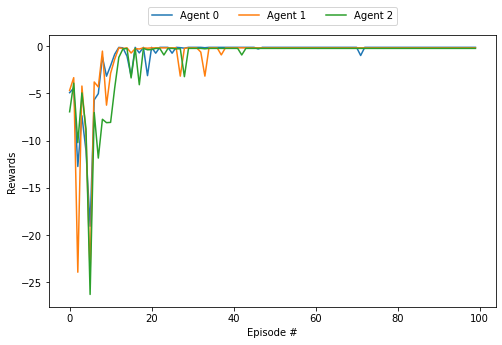

In [ ]:
plot_graphs(agents_stats, failed_transitions)

In [ ]:
index = 2
print(malp_states_and_actions[0][index])

for agents in range(num_of_agents):
  print(ma_Q[agents][index])

print(malp_states_and_actions[1][index])

['S2_A0', 'S2_A1', 'S2_A2', 'S2_A3', 'S2_A4']
[-1.00123203 -0.7266     -0.489      -0.84048    -1.8       ]
[-0.93773756 -0.91423473 -0.92126054 -0.908      -1.8       ]
{'S2_A0': [0, 511, 7, 908, 0.93], 'S2_A1': [1, 314, 9, 990, 0.829], 'S2_A2': [0, 708, 7, 836, 0.405], 'S2_A3': [1, 769, 7, 910, 0.824], 'S2_A4': [2, 867, 9, 898, 0.247]}
